## 1. Re-tiling

In [ ]:
# details of the re-tiling schema
grid = {
    'min_x': -113107.81,
    'max_x': 398892.19,
    'min_y': 214783.87,
    'max_y': 726783.87,
    'n_tiles_side': 512
}

# setup input dictionary to configure the re-tiling pipeline 
retiling_input = {
    'setup_local_fs': {
        'input_folder': remote_path_input.as_posix(),
        'output_folder': remote_path_output.as_posix()
    },
    'set_grid': grid,
    'split_and_redistribute': {},
    'validate': {}
}

## 2. Normalization

In [ ]:
# setup input dictionary to configure the normalization pipeline
normalization_input = {
    'setup_local_fs': {'input_folder': path_input.as_posix(),
                       'output_folder': path_output.as_posix()},
    'load': {'attributes': 'all'},
    # filter out artifically high points - give overflow error when writing 
    'apply_filter': {'filter_type':'select_below',
                     'attribute': 'z',
                     'threshold': 10000.},  # remove non-physically heigh points
    'normalize': 1, # define the cell size for normalization, here is 1 m × 1 m 
    'clear_cache' : {},
}

## 3. Feature extraction

In [ ]:
# define custom feature extractors, here we extract the band_ratio_5<normalized_height<20.
custom_feature_extractors = [{'extractor_name': 'BandRatioFeatureExtractor', 
                              'data_key': z, # z represents the normalized height
                              'lower_limit': low_lim,        
                              'upper_limit': up_lim} for low_lim, up_lim in (5, 20)]

# setup input dictionary to configure the feature extraction pipeline
feature_extraction_input = {
    'setup_local_fs': {'input_folder': path_input.as_posix(),
                       'output_folder': path_output.as_posix()},
    'load': {'attributes': ['raw_classification', 'normalized_height']}, 
    'add_custom_features': {
         # add user-defined custom features to the input
        'custom_feature_list': custom_feature_extractors
    },
    'apply_filter': {
        'filter_type': 'select_equal',
        'attribute': 'raw_classification',
        # define the class of points used for calculation (i.e. vegetation points)
        # it may vary from different datasets (based on the pre-classification code)
        'value': 1 # for AHN3, 1 represents the unclassified points, i.e. vegetation points.
    },
    'generate_targets': {
        'tile_mesh_size' : 10, # define the resolution for the final products, here is 10 m
        'validate' : True,
        'validate_precision': 1.e-3, # solves numerical issues for points on the edge
        **grid
    },
    'extract_features': {
         # define the feature name(s) 
        'feature_names': ['perc_95_normalized_height', 'band_ratio_5<normalized_height<20'],
        'volume_type': 'cell',
        'volume_size': 10
    },
    'export_targets': {
        'attributes': ['perc_95_normalized_height', 'band_ratio_5<normalized_height<20'],
        'multi_band_files': False,
        'overwrite': True
    },
    'clear_cache' : {},
}

## 4. Rasterization

In [ ]:
# output handle: AHN3 dataset, features, target grid spacing 10m, 
# normalization grid spacing 1m, vegetation points
output_handle = 'AHN3_feat_10m_1m_veg'

# setup input dictionary to configure the geotiff export pipeline
geotiff_export_input_nonground = {
    'parse_point_cloud': {},
    'data_split': {'xSub': 1, 'ySub': 1},
    'create_subregion_geotiffs': {'output_handle': output_handle},
}

## Laserchicken

In [3]:
from laserchicken import load
point_cloud = load('/project/lidarac/Data/Figure_Normalized/tile_279_227.laz')

In [4]:
from laserchicken.filter import select_equal
point_cloud = select_equal(point_cloud, 'raw_classification', 1)

In [ ]:
from laserchicken import compute_neighborhoods
from laserchicken import compute_features
from laserchicken import build_volume
from laserchicken import register_new_feature_extractor
from laserchicken.feature_extractor.band_ratio_feature_extractor import BandRatioFeatureExtractor
register_new_feature_extractor(BandRatioFeatureExtractor(5,20,data_key='normalized_height'))
targets = point_cloud
volume = build_volume("cell", side_length=10)
neighborhoods = compute_neighborhoods(point_cloud, targets, volume)
compute_features(point_cloud, neighborhoods, targets, ['perc_95_normalized_height', 'band_ratio_5<normalized_height<20'], volume)

In [ ]:
from laserchicken import export
export(point_cloud, 'tile_279_227_output.laz')

In [3]:
import numpy as np
import laserchicken as lc
from matplotlib import pyplot as plt

def visualize_pc(pc, col, npmax=None, clabel=None, pointsize=3):
    """
    pc: input pointcloud
    col: data column to be visualized
    npmax: max number of points to visualize
    clable: colorbar lable
    pointsize: visualized point size 
    """
    fig, ax = plt.subplots()
    npoints = pc['vertex']['x']['data'].shape[0]
    x, y, data = lc.utils.get_features(pc, ['x', 'y', col])
    if npmax is not None:
        if npoints>npmax: # vilsualize up to npmax points
            idx=np.random.choice(range(npoints),npmax)
            x = x[idx]
            y = y[idx]
            data = data[idx]
    sc = ax.scatter(x, y, c = data, s = pointsize)
    ax.grid()
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('RD x [m]')
    ax.set_ylabel('RD y [m]')
    fig.colorbar(sc, label=clabel)
    plt.show()

In [14]:
from laserchicken import load
point_cloud = load('/project/lidarac/Data/Figure_Targets_veg/band_ratio_5<normalized_height<20/tile_279_227_modi.ply')

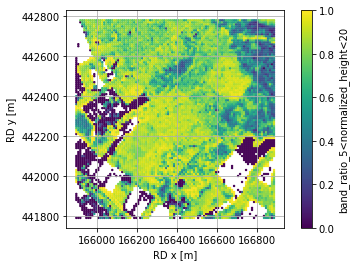

In [15]:
visualize_pc(point_cloud, col='band_ratio_5<z<20', clabel='band_ratio_5<normalized_height<20', pointsize=2)

In [16]:
from laserchicken import export
export(point_cloud, '/project/lidarac/Data/Figure_Targets_veg/band_ratio_5<normalized_height<20/tile_279_227.laz')